Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

We will go through the following steps:

- 1. Importing libraries and the dataset
- 2. Data preparation: Train-validation split, test set, specifying the shape of the input data etc.

- 3. Without Augmentation strategy CNN Model
     - A. Building and understanding the CNN architecture
     - B. Fitting and evaluating the model

- 4. Use Augmentation strategy in building CNN Model
     - A. Create Augmentation strategy
     - B. Building and understanding the CNN architecture
     - C. Fitting and evaluating the model

- 5. Use Augmentor lib in building CNN Model
     - A. Add more samples using Augmentor lib
     - B. Building and understanding the CNN architecture
     - C. Fitting and evaluating the model

- 6. Predict on image from Test dataset

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
from pickle import load
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from matplotlib.pyplot import imshow
from glob import glob

In [2]:
# ## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

# ##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2360 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# # Defining the path for train and test images
# data_dir_train = pathlib.Path("/content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
# data_dir_test = pathlib.Path("/content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [6]:
# Print number of images in Train and Test dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train data set size: " + str(image_count_train))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test data set size: " + str(image_count_test))

Train data set size: 2239
Test data set size: 121


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility. Data set fetched helps in identifying classes and backpropagation.

### Create a dataset

Define some parameters for the loader:

In [48]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [49]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [51]:
## Get test data set which remains unseen from training CNN
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test, batch_size=32, image_size=(180, 180), label_mode='categorical', seed=123
)

Found 121 files belonging to 9 classes.


In [52]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize one instance of all the nine classes present in the dataset

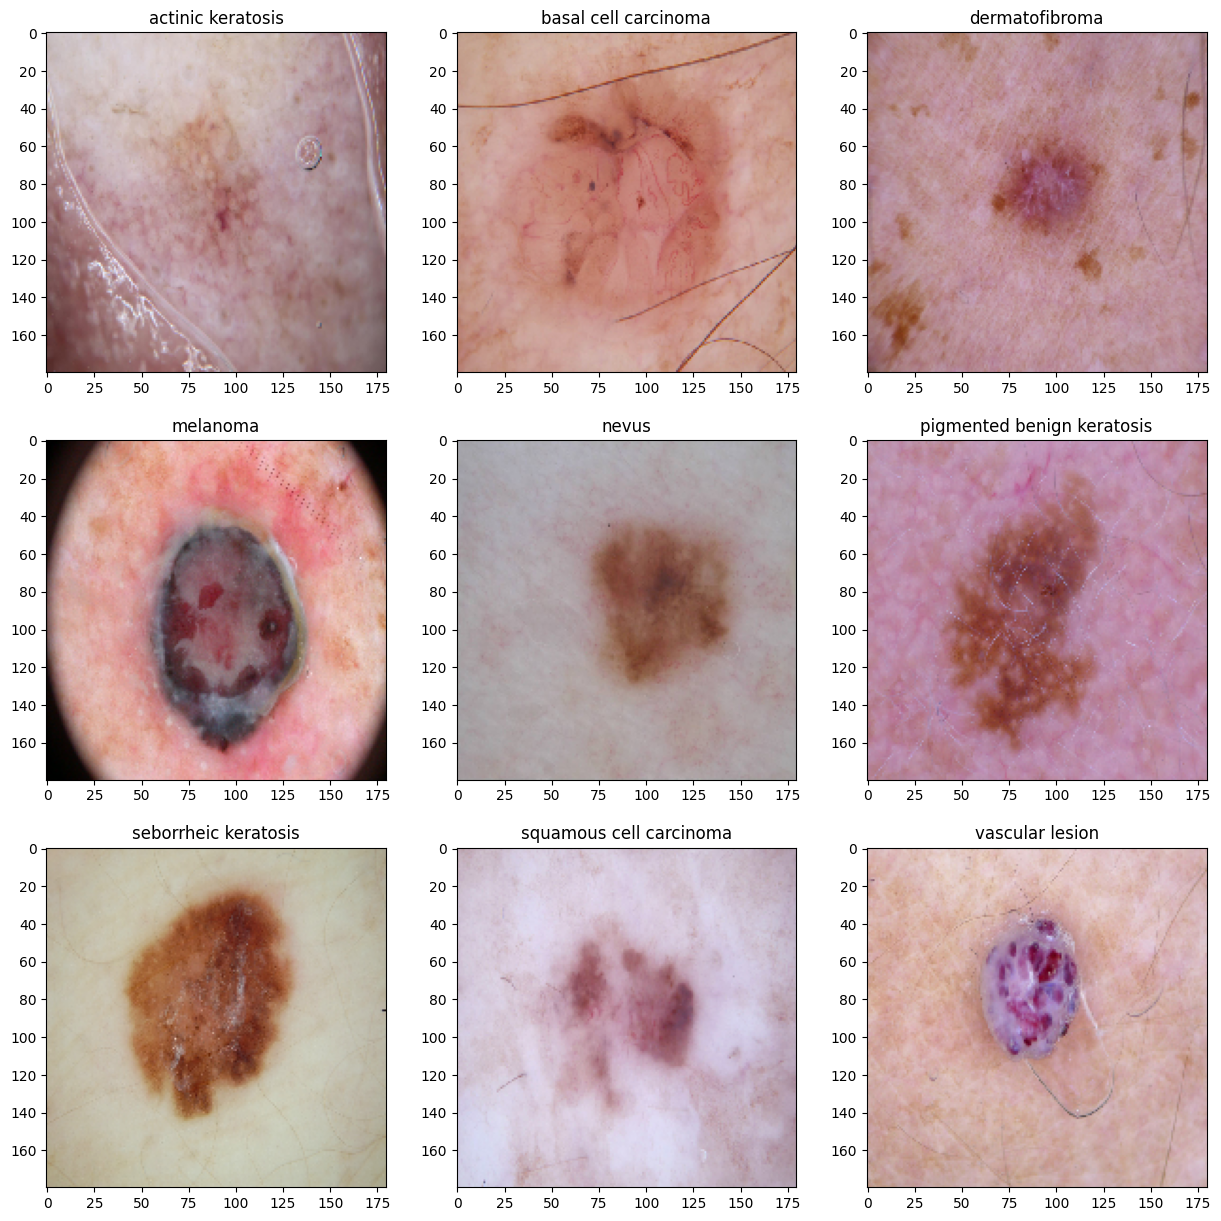

In [53]:
import matplotlib.pyplot as plt

# Dictionary to store image paths for each class
files_path_dict = {}

# Loop through each class to gather image paths
for class_name in class_names:
    files_path_dict[class_name] = list(map(lambda x: str(data_dir_train) + '/' + class_name + '/' + x, os.listdir(str(data_dir_train) + '/' + class_name)))

# Visualize an image from each class
plt.figure(figsize=(15, 15))
index = 0
for class_name in class_names:
    path_list = files_path_dict[class_name][:1]
    index += 1
    plt.subplot(3, 3, index)

    # Load and display the image
    plt.imshow(load_img(path_list[0], target_size=(180, 180)))
    plt.title(class_name)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

Let's now build the CNN architecture.

We will build a network with:

- Rescaling input image to (180,180,3)
- 3 convolutional layers having 32, 64, 128 filters respectively,
- followed by a max pooling layer after each convolution layer
- and then Flatten the output of the pooling layer to give us a long vector,
- then add a fully connected Dense layer with 128 neurons
- and finally, add a softmax layer with 9 neurons
- padding is not used, stride is with default value 1
- ReLU activation function is used in all neurons except last output layer

In [54]:
# Method to add layers in CNN Model Architecture
# Sequential allows you to create models layer-by-layer
def add_model_layers(model):

    # Rescaling Layer: Scale input pixel values to the [0, 1] range
    model.add(layers.Rescaling(1./255, input_shape=(180, 180, 3)))

    # First Convolutional unit
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Second Convolutional unit
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Third Convolutional unit
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Flatten Layer: Convert multi-dimensional input tensors into a single dimension
    model.add(layers.Flatten())

    # Dense Layer 2: Fully connected layer with 128 units and ReLU activation
    model.add(layers.Dense(128, activation='relu'))

    # Dense Layer with softmax activation function to give output as probabilities
    model.add(layers.Dense(len(class_names), activation='softmax'))

    return model

In [55]:
# Create sequential model without Augmentation strategy
# The generic way to build a model in Keras is to instantiate a Sequential model and keep adding keras.layers to it.
model_without_aug = Sequential()
model_without_aug = add_model_layers(model_without_aug)

### Compile the model
Choose an appropirate optimiser and loss function for model training
- SparseCategoricalCrossentropy is used as output is multi classification values

In [56]:
# View the summary of all layers
model_without_aug.compile(optimizer="Adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
model_without_aug.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

`reshuffle_each_iteration` is made True when adding shuffle. It allows you to choose whether to reshuffle at repeats of the data (every time the original data has been iterated over).

In [57]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(20*batch_size, reshuffle_each_iteration=True).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train the model

In [58]:
# Train model with 20 epochs.
# Use train and validation dataset for training model and calculating accuracy score
epochs = 20
history = model_without_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 853s 4s/step - accuracy: 0.1812 - loss: 2.3574 - val_accuracy: 0.3893 - val_loss: 1.8025
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.3908 - loss: 1.6972 - val_accuracy: 0.3826 - val_loss: 1.6594
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4697 - loss: 1.4626 - val_accuracy: 0.5213 - val_loss: 1.4446
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5093 - loss: 1.4088 - val_accuracy: 0.4944 - val_loss: 1.4327
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5312 - loss: 1.3324 - val_accuracy: 0.4452 - val_loss: 1.5379
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5368 - loss: 1.2910 - val_accuracy: 0.4787 - val_loss: 1.5756
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5784 - loss: 1.1826 - val_accuracy: 0.5257 - val_loss: 1.3789
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5989 - loss: 1.1160 - val_accuracy: 0.5302 - 

### Visualizing training results

In [59]:
# Plot Training vs Validation accuracy score
# Plot Training vs Validation loss score
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

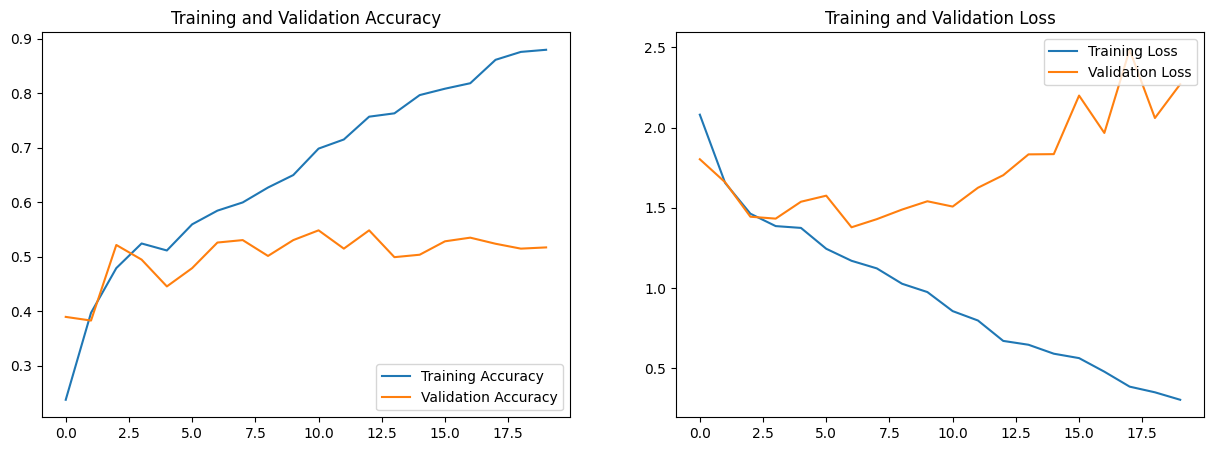

In [60]:
plot_accuracy_loss(history)

### Observations:

- The model demonstrates a consistent increase in training accuracy, reaching up to 83%, while the validation accuracy remains stable at approximately 54% in 20 epochs.

- The substantial gap between training and validation accuracy indicates that the model has likely learned to fit the noise present in the training data, rather than generalizing well to unseen data. This suggests that overfitting may be occurring.

#### To mitigate this issue, data augmentation techniques will be applied. Given the limited size of the training dataset, augmented samples will be generated by applying slight variations to the existing data, such as horizontal and vertical image flipping, minor rotations, contrast change. These augmented samples will be used to train the model, with the goal of improving its generalizability.

In [61]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
  ]
)

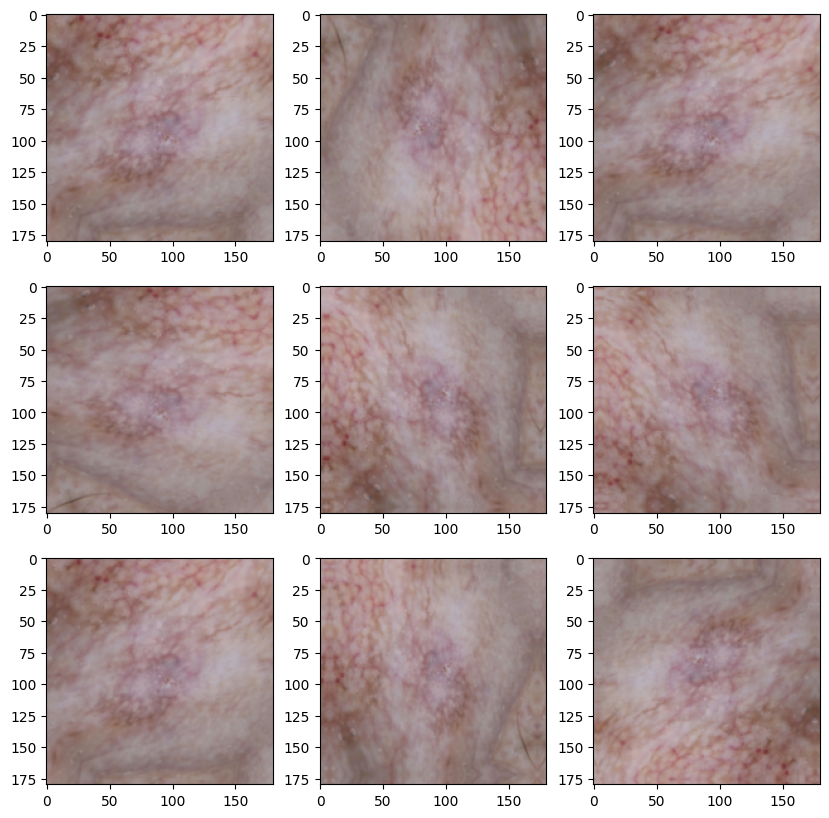

In [62]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))

### Create the model, compile and train the model


In [63]:
# CNN Model Architecture
# Sequential allows you to create models layer-by-layer
# Add augmentation layer for sampling of existing images
# Add other layers similar to earlier model
model_aug = Sequential()
model_aug.add(data_augmentation)
model_aug = add_model_layers(model_aug)

### Compiling the model

In [64]:
# View the summary of all layers
model_aug.compile(optimizer="Adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
model_aug.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(20*batch_size, reshuffle_each_iteration=True).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Training the model

In [66]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2236 - loss: 2.1184 - val_accuracy: 0.3848 - val_loss: 1.7022
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4261 - loss: 1.6205 - val_accuracy: 0.4541 - val_loss: 1.5286
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4891 - loss: 1.4961 - val_accuracy: 0.5145 - val_loss: 1.3839
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5062 - loss: 1.3924 - val_accuracy: 0.5168 - val_loss: 1.3789
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5359 - loss: 1.3401 - val_accuracy: 0.4922 - val_loss: 1.4281
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5345 - loss: 1.3374 - val_accuracy: 0.5213 - val_loss: 1.3643
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5501 - loss: 1.2901 - val_accuracy: 0.5145 - val_loss: 1.3735
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5360 - loss: 1.2698 - val_accuracy: 0.5459 - v

### Visualizing the results

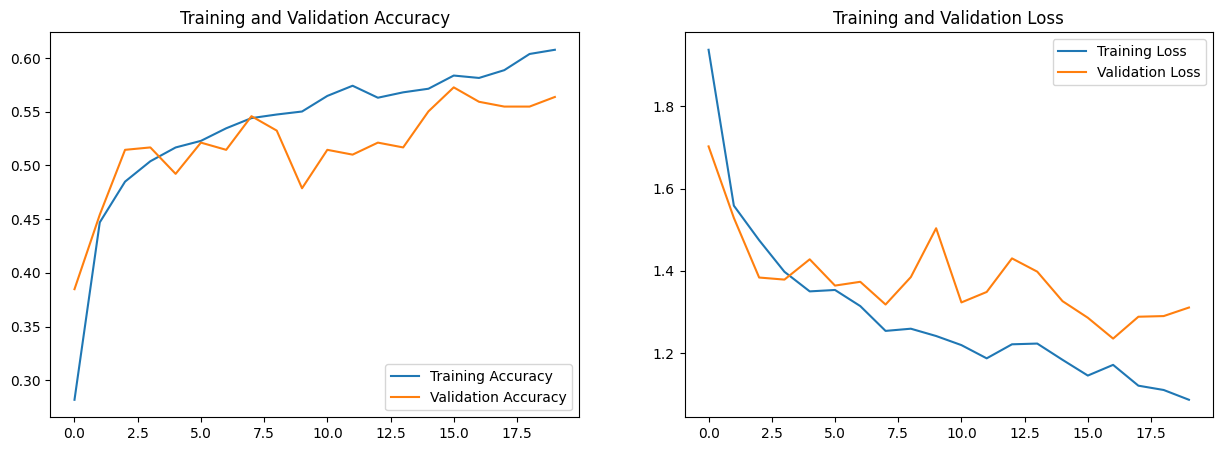

In [67]:
plot_accuracy_loss(history)

### Observations
1. The implementation of data augmentation has effectively mitigated overfitting, improving generalization.
2. Both the training and validation accuracy are currently within a similar range
3. Accuracy value is low and stable in the range of 50-53%, making it underfit. Model is not performing on either the training or validation data. This suggests that the model is too simplistic or lacks the capacity to learn complex patterns in the data, which is typical in cases of underfitting.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [68]:
## Your code goes here.
# Define a function to count and analyze the distribution of images in each class

def class_distribution_count(directory):
    # Initialize a list to store image counts for each class
    count = []

    # Count the number of images in each class directory
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count_files=0
            for name in os.listdir(path):
                if os.path.isfile(os.path.join(path, name)):
                    count_files=count_files+1
                else:
                    count_files=count_files+len([name1 for name1 in os.listdir(os.path.join(path, "output"))])
            count.append(count_files)

    # Get the names of the classes (sub-directories)
    sub_directory = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

    # Create a DataFrame with class names and corresponding image counts
    df = pd.DataFrame(list(zip(sub_directory, count)), columns=['Class name', 'No. of Images'])

    # Sort the DataFrame in ascending order of image counts
    df = df.sort_values(by='No. of Images', ascending=True)

    total_sum=df["No. of Images"].sum()
    class_percentage = df[["No. of Images"]] * 100 / total_sum
    class_percentage_rounded = class_percentage.round(2)
    df["Percentage"] = class_percentage_rounded
    print("\nClass distribution:")
    print(df)

    # Return the sorted DataFrame
    return df

# Call the function to get the class distribution and image count
class_distribution_df = class_distribution_count(data_dir_train)


Class distribution:
                   Class name  No. of Images  Percentage
6        seborrheic keratosis             77        3.44
7              dermatofibroma             95        4.24
0           actinic keratosis            114        5.09
5             vascular lesion            139        6.21
3     squamous cell carcinoma            181        8.08
8                       nevus            357       15.94
4        basal cell carcinoma            376       16.79
1                    melanoma            438       19.56
2  pigmented benign keratosis            462       20.63


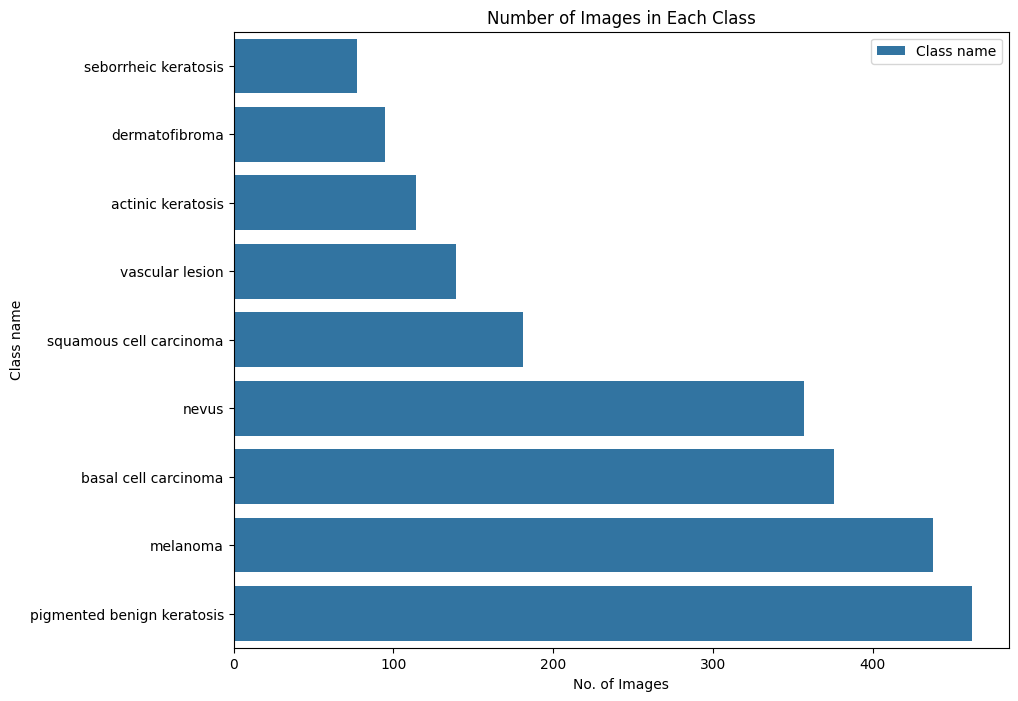

In [69]:
# Visualize the Number of Images in Each Class

# Import the seaborn library for data visualization
import seaborn as sns

# Set the size of the plot figure
plt.figure(figsize=(10, 8))

# Create a bar plot using seaborn
sns.barplot(x="No. of Images", y="Class name", data= class_distribution_df, label="Class name")

# Add a title to the plot
plt.title("Number of Images in Each Class")

# Display the plot
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
        -"seborrheic keratosis" clas has least number of samples as 77

#### - Which classes dominate the data in terms proportionate number of samples?
        - "pigmented benign keratosis" has highest proportion of samples with 20.63% share
        - "melanoma" has 19.56% share
        - "Basal cell carcinoma" has 16.79% share
        - "Nevus" has 15.94% share


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [70]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.
4. Use rotate, flip, crop, zoom, skew, shear, distortion in creating samples like real time images

In [71]:
import Augmentor
path_to_training_dataset=str(data_dir_train)
for i in class_names:
    class_name_path=path_to_training_dataset + "/" + i
    class_name_output_img_count = len(list(glob(class_name_path + '/output/*')))
    if (class_name_output_img_count > 0):
        print(f"Augmented images for class: {i}, total images present: {class_name_output_img_count}")
    else:
        print(f"Not augmented images for class: {i}")
        p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
        p.rotate(probability=0.4, max_left_rotation=10, max_right_rotation=10)
        p.skew(probability=0.1, magnitude=0.1)
        p.zoom(probability=0.1, min_factor=1.1, max_factor=1.2)
        p.crop_random(probability=0.1, percentage_area=0.1)
        p.shear(probability=0.1, max_shear_left=5, max_shear_right=5)
        p.flip_random(probability=0.1)
        p.random_distortion(probability=0.1, grid_width=4, grid_height=4, magnitude=8)
        p.sample(1000) ## We are adding 1000 samples per class to make sure that none of the classes are sparse.
        print(f"Augmented images for class: {i}")

Not augmented images for class: actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C1E24694E10>: 100%|██████████| 1000/1000 [00:49<00:00, 20.15 Samples/s]


Augmented images for class: actinic keratosis
Not augmented images for class: basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C1E2413C3D0>: 100%|██████████| 1000/1000 [00:40<00:00, 24.46 Samples/s]


Augmented images for class: basal cell carcinoma
Not augmented images for class: dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C1E24548A90>: 100%|██████████| 1000/1000 [00:40<00:00, 24.63 Samples/s]


Augmented images for class: dermatofibroma
Not augmented images for class: melanoma
Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7C1E24147BD0>: 100%|██████████| 1000/1000 [03:33<00:00,  4.69 Samples/s]


Augmented images for class: melanoma
Not augmented images for class: nevus
Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7C1E19E0E050>: 100%|██████████| 1000/1000 [03:16<00:00,  5.10 Samples/s]


Augmented images for class: nevus
Not augmented images for class: pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C1E32105290>: 100%|██████████| 1000/1000 [00:42<00:00, 23.70 Samples/s]


Augmented images for class: pigmented benign keratosis
Not augmented images for class: seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C1E24323D50>: 100%|██████████| 1000/1000 [01:30<00:00, 10.99 Samples/s]


Augmented images for class: seborrheic keratosis
Not augmented images for class: squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C1E256381D0>: 100%|██████████| 1000/1000 [00:44<00:00, 22.37 Samples/s]


Augmented images for class: squamous cell carcinoma
Not augmented images for class: vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C1E321AC2D0>: 100%|██████████| 1000/1000 [00:43<00:00, 22.82 Samples/s]

Augmented images for class: vascular lesion


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

### Lets see the distribution of augmented data after adding new images to the original training data.

In [72]:
path_list_new = list(glob(os.path.join(data_dir_train, '*','output', '*.jpg')))
path_list_new[:5]

['/content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026626.jpg_16489ee9-7a44-4590-a70b-61148d4b8898.jpg',
 '/content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_e9648857-28e0-44e7-a370-ca2ad6d3b064.jpg',
 '/content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026857.jpg_6a8b2f18-60e4-491c-b731-4d4bccacd341.jpg',
 '/content/gdrive/My Drive/Data Science/CNN/Melanoma detection assignment/original_images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic

In [73]:
# Class names of Augmented output files
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [74]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [75]:
# Data frame of augmented output files with class names
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Class name','Path'])
new_df.head()

,Class name,Path
0,/content/gdrive/My Drive/Data Science/CNN/Mela...,actinic keratosis
1,/content/gdrive/My Drive/Data Science/CNN/Mela...,actinic keratosis
2,/content/gdrive/My Drive/Data Science/CNN/Mela...,actinic keratosis
3,/content/gdrive/My Drive/Data Science/CNN/Mela...,actinic keratosis
4,/content/gdrive/My Drive/Data Science/CNN/Mela...,actinic keratosis


In [76]:
# Percentage share of augmented output with original images, hence total training data set
class_distribution_df = class_distribution_count(data_dir_train)


Class distribution:
                   Class name  No. of Images  Percentage
6        seborrheic keratosis           1077        9.58
7              dermatofibroma           1095        9.74
0           actinic keratosis           1114        9.91
5             vascular lesion           1139       10.13
3     squamous cell carcinoma           1181       10.51
8                       nevus           1357       12.07
4        basal cell carcinoma           1376       12.24
1                    melanoma           1438       12.79
2  pigmented benign keratosis           1462       13.01


#### Class imbalance has been rectified in new data set

#### Train the model on the data created using Augmentor

#### Create a training dataset after Augmentor sampling

In [77]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### Create a validation dataset after Augmentor sampling

In [78]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [79]:
#Get all class names after Augmentor sampling
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Create model

Let's now build improved CNN architecture.

We will build a network with:

- Rescaling each input to (180,180,3) for normlaization
- 4 convolutional layers having 32, 64, 128, 256 filters respectively,
- followed by a max pooling layer after each convolution layer
- and then Flatten the output of the pooling layer to give us a long vector,
- then add 2 fully connected Dense layer with 256, 128 neurons
- and finally, add a softmax layer with 9 neurons
- The generic way to build a model in Keras is to instantiate a Sequential model and keep adding keras.layers to it.
- We will also use some dropouts in few of the layers to overcome overfitting
- padding is not used, stride is with default value 1
- ReLU activation function is used in all neurons except last output layer

In [96]:
# Method to add layers in CNN Model Architecture
# Sequential allows you to create models layer-by-layer
def add_model_layers(model):

    # Rescaling Layer: Scale input pixel values to the [0, 1] range
    model.add(layers.Rescaling(1./255, input_shape=(180, 180, 3)))

    # First Convolutional unit
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.2))

    # Second Convolutional unit
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.2))

    # Third Convolutional unit
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    # Fourth Convolutional unit
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.4))

    # Flatten Layer: Convert multi-dimensional input tensors into a single dimension
    model.add(layers.Flatten())

    # Dense Layer 1: Fully connected layer with 256 units and ReLU activation
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))

    # Dense Layer 2: Fully connected layer with 128 units and ReLU activation
    model.add(layers.Dense(128, activation='relu'))

    # Dense Layer with softmax activation function to give output as probabilities
    model.add(layers.Dense(len(class_names), activation='softmax'))

    return model

In [97]:
# Create Sequential layer in CNN architecture
model_augmentor = Sequential()
model_augmentor = add_model_layers(model_augmentor)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [98]:
# View the summary of all layers
model_augmentor.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_augmentor.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │       5,308,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,731,145 (21.86 MB)

 Trainable params: 5,731,145 (21.86 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(20*batch_size, reshuffle_each_iteration=True).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:**  Train your model

In [100]:
# Train model with 30 epochs.
# Use train and validation dataset for training model and calculating accuracy score

epochs = 30
history = model_augmentor.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.1438 - loss: 2.1924 - val_accuracy: 0.2893 - val_loss: 1.9168
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.2966 - loss: 1.7939 - val_accuracy: 0.3591 - val_loss: 1.6248
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.3798 - loss: 1.5955 - val_accuracy: 0.3485 - val_loss: 1.6500
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.3896 - loss: 1.5656 - val_accuracy: 0.3307 - val_loss: 1.6784
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.4091 - loss: 1.5327 - val_accuracy: 0.4215 - val_loss: 1.4497
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.4568 - loss: 1.4164 - val_accuracy: 0.4397 - val_loss: 1.4014
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4910 - loss: 1.3329 - val_accuracy: 0.5265 - val_loss: 1.2717
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.5240 - loss: 1.2417 - 

#### **Todo:**  Visualize the model results

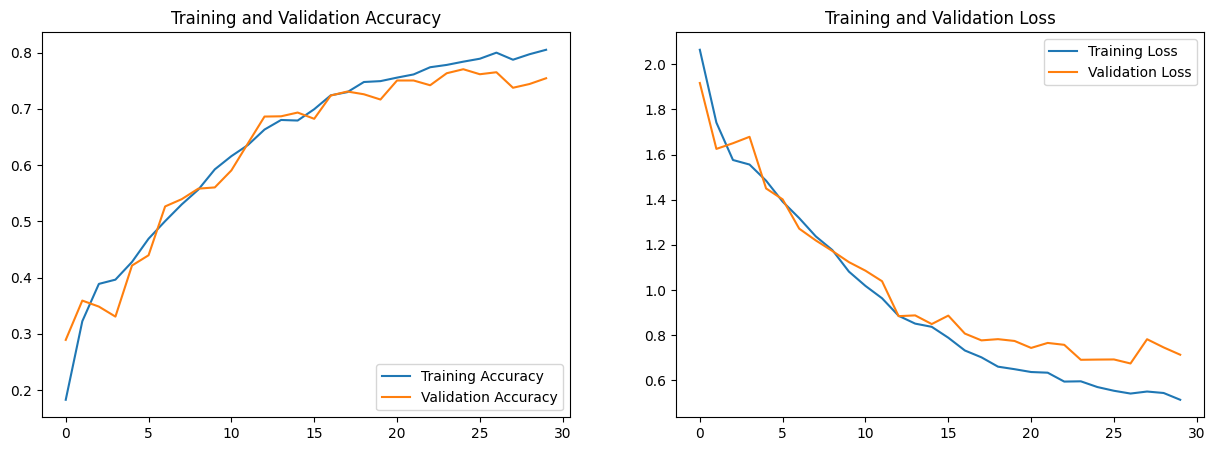

In [101]:
plot_accuracy_loss(history)

### Observations
1. Class rebalance has improved train and validation accuracy to great extent as both training and validation accuracy is more than 75%, hence not underfit
2. Model validation and train accuracy is very close, hence not overfit
3. Model has come out of underfitting problem and accuracy is much higher than random guessing
4. Adding more training data set with distorted/flipped/zoomed/cropped images like real life images helped improve the model

### Predict on one of the test data set for verification

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Actual Class: melanoma
Predictive Class: melanoma


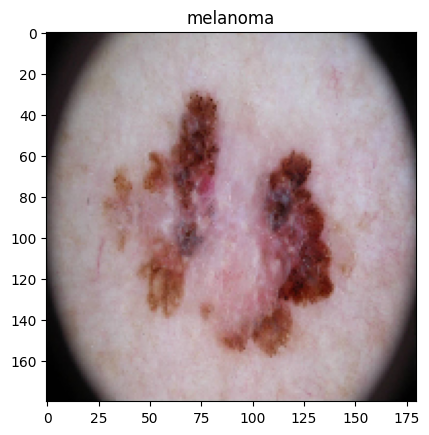

In [120]:
Test_image_path = os.path.join(data_dir_test, class_names[3], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[9],target_size=(180,180))

plt.imshow(Test_image)
plt.title(class_names[3])
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model_augmentor.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[3]}" + '\n' + "Predictive Class: " + pred_class)

In [ ]:
for class_name_index in range(len(class_names)):
  Test_image_path = os.path.join(data_dir_test, class_names[class_name_index], '*')
  Test_image = glob(Test_image_path)
  Test_image = load_img(Test_image[-1],target_size=(180,180))

  img = np.expand_dims(Test_image,axis=0)
  pred = model_augmentor.predict(img)
  pred = np.argmax(pred)
  pred_class = class_names[pred]
  print(f"Actual Class: {class_names[class_name_index]}" + '\n' + "Predictive Class: " + pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Actual Class: actinic keratosis
Predictive Class: actinic keratosis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Actual Class: basal cell carcinoma
Predictive Class: actinic keratosis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Actual Class: dermatofibroma
Predictive Class: dermatofibroma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Actual Class: melanoma
Predictive Class: nevus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Actual Class: nevus
Predictive Class: nevus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Actual Class: pigmented benign keratosis
Predictive Class: pigmented benign keratosis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Actual Class: seborrheic keratosis
Predictive Class: melanoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Actual Class: squamous cell carcinoma
Predictive Class: squamous cell carcinoma


### Observations
1. Predicting model output on completely unseed test data set showing similar results as training accuracy.
2. Ranomly selected image with Melanoma symptoms correctly predicted with model
3. Prediction on 1 sample of each symptom is very close to actual classification.

## Conclusion

- 3 models are built
- Because of limited images, simple model was overfitted
- After applying augmentation strategy in CNN model layer, overfitting issue was overcome, but model was underfit
- After adding sample variation of images of each classification, model performed better and both overfit and underfit problems were resolved
- Model predictions on test unseen data also working as per training accuracy
- Hence melanoma deteciton can be better predicted with final last model with much higher accuracy than random guessing.